In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download_kaggle_dataset ('https://www.kaggle.com/datasets/jangedoo/utkface-new', data_dir='/content/sample_data')

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new


100%|██████████| 331M/331M [00:05<00:00, 62.7MB/s]


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
age =[]
gender=[]
img_path =[]

for file in os.listdir ('/content/sample_data/utkface-new/UTKFace'):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [4]:
df= pd.DataFrame ({'age':age,'gender':gender,'img_path':img_path})
df.shape

(23708, 3)

In [5]:
train_df = df.sample(frac=1, random_state =0).iloc [ :20000]
test_df = df.sample(frac=1, random_state =0).iloc [20000:]
train_df.shape,test_df.shape

((20000, 3), (3708, 3))

In [8]:
train_ages = train_df['age'].astype('float32').values
train_genders = train_df['gender'].astype('float32').values # Removed the mapping

val_ages = test_df['age'].astype('float32').values
val_genders= test_df['gender'].astype('float32').values # Removed the mapping

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Custom generator to yield images and a dictionary of outputs
def multi_output_generator(generator, age_labels, gender_labels):
    while True:
        i = 0
        for x in generator:
            batch_ages = age_labels[i:i + x.shape[0]]
            batch_genders = gender_labels[i:i + x.shape[0]]
            i += x.shape[0]
            yield x, {'age': batch_ages, 'gender': batch_genders}
            if i >= len(age_labels):
                i = 0 # Reset for the next epoch

train_datagen = ImageDataGenerator (
    rescale=1./255,
)
train_flow= train_datagen.flow_from_dataframe (
    train_df,
    directory='/content/sample_data/utkface-new/UTKFace',
    x_col='img_path',
    y_col=['age','gender'],
    target_size=(224,224),
    batch_size=32,
    class_mode=None, # Set class_mode to None
    shuffle=False # Set shuffle to False here and handle shuffling in the custom generator if needed
)

val_datagen = ImageDataGenerator (
    rescale=1./255
)
val_flow= val_datagen.flow_from_dataframe (
    test_df,
    directory ='/content/sample_data/utkface-new/UTKFace',
    x_col='img_path',
    y_col=['age', 'gender'],
    target_size=(224,224),
    batch_size=32,
    class_mode= None, # Set class_mode to None
    shuffle=False # Set shuffle to False here
)

# Create custom generators
train_data = multi_output_generator(train_flow, train_ages, train_genders)
val_data = multi_output_generator(val_flow, val_ages, val_genders)

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [10]:
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [11]:
vggnet = VGG16 (
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)

)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
vggnet.trainable = False
output= vggnet.layers [-1].output
flatten = Flatten () (output)
dense1= Dense (256,activation='relu') (flatten)
dense2= Dense (128,activation='relu') (flatten)

dense3 = Dense (512, activation='relu')(dense1)
dense4 = Dense  (512, activation='relu')( dense2)

output1= Dense (1, activation='linear', name='age') (dense3)
output2= Dense (1, activation='sigmoid', name='gender') (dense4)

model = Model (inputs=vggnet.input, outputs=[output1,output2])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 24,547,522 (93.64 MB)

 Trainable params: 9,832,834 (37.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

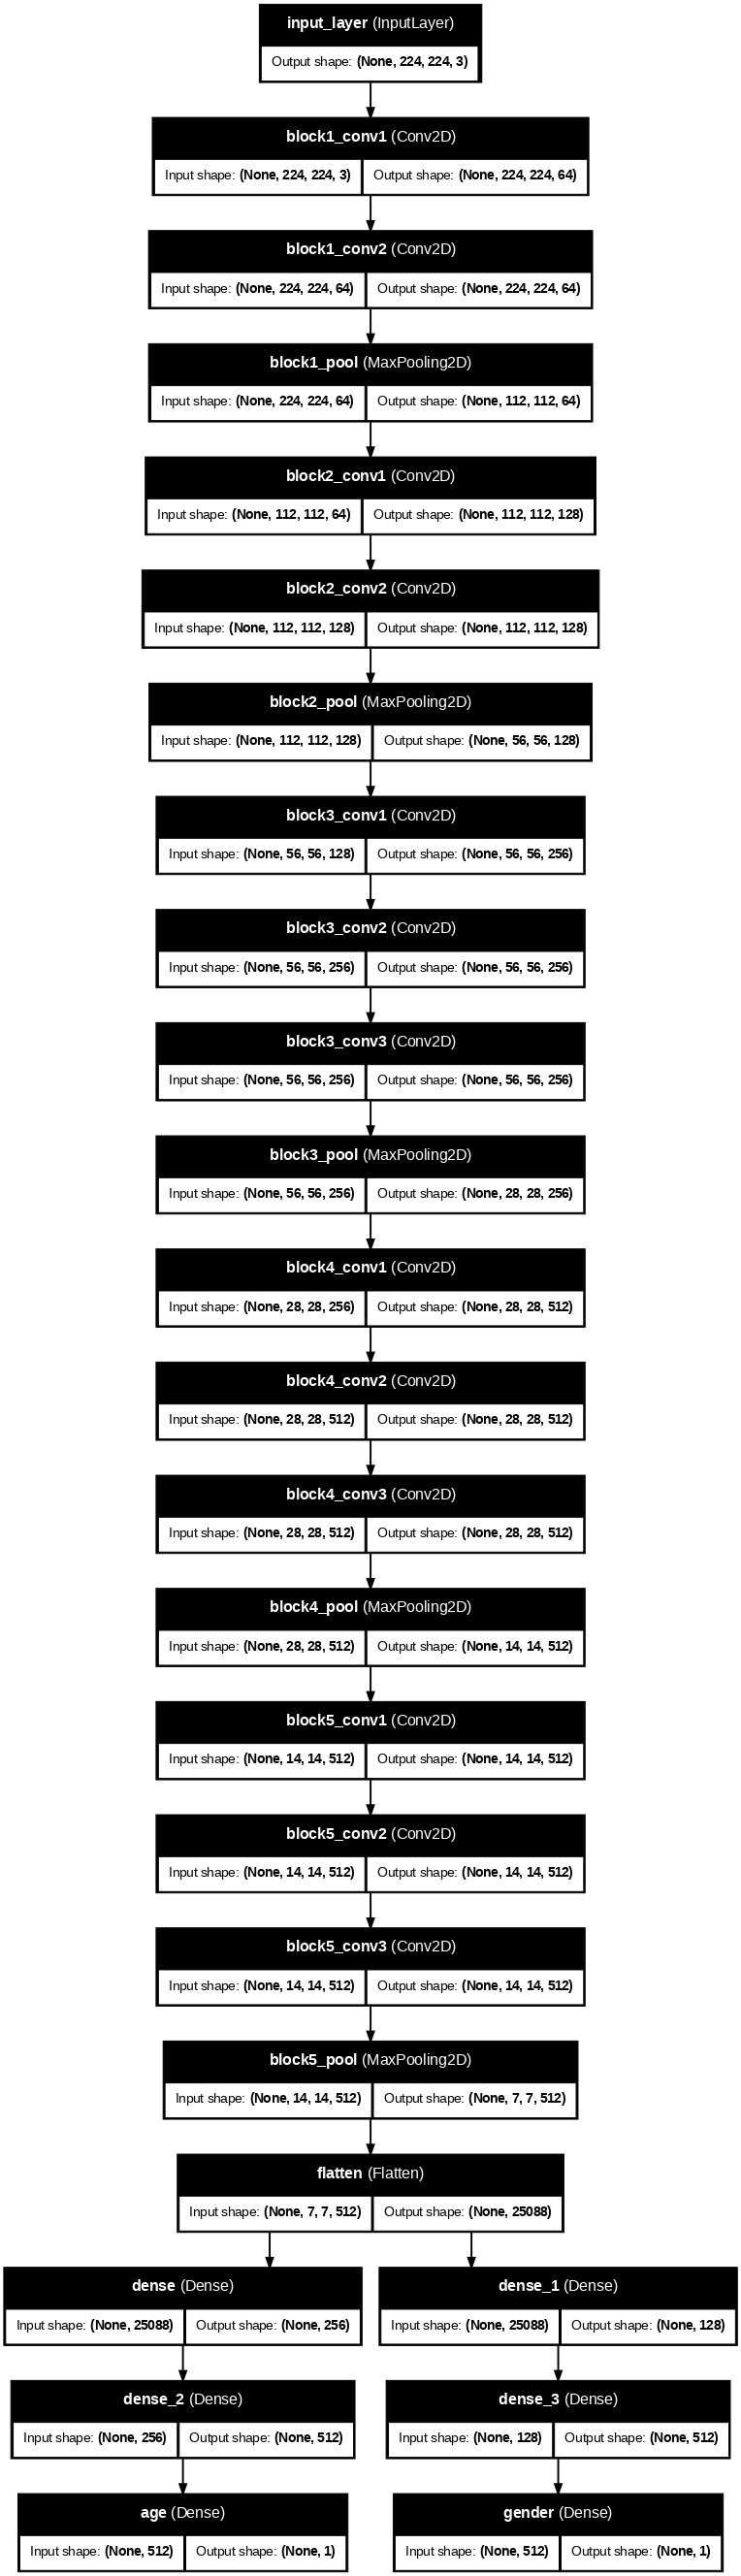

In [13]:
from re import S
from keras.utils import plot_model
plot_model (model, show_shapes = True, show_layer_names = True, dpi=70)

In [14]:
model.compile (optimizer='adam', loss={'age':'mae','gender': 'binary_crossentropy'}, metrics={'age': 'mae','gender' : 'accuracy'}
               )

In [15]:
model.fit(
    x=train_data,
    validation_data=val_data,
    epochs=3,
    steps_per_epoch=len(train_flow), # Use the length of the original flow for steps_per_epoch
    validation_steps=len(val_flow) # Use the length of the original flow for validation_steps
)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 234ms/step - age_loss: 10.5891 - age_mae: 10.5891 - gender_accuracy: 0.7953 - gender_loss: 0.4283 - loss: 11.0175 - val_age_loss: 7.5919 - val_age_mae: 7.5914 - val_gender_accuracy: 0.8568 - val_gender_loss: 0.3049 - val_loss: 7.8963
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 216ms/step - age_loss: 7.4634 - age_mae: 7.4634 - gender_accuracy: 0.8797 - gender_loss: 0.2691 - loss: 7.7325 - val_age_loss: 7.2398 - val_age_mae: 7.2398 - val_gender_accuracy: 0.8761 - val_gender_loss: 0.2826 - val_loss: 7.5224
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 216ms/step - age_loss: 6.7020 - age_mae: 6.7020 - gender_accuracy: 0.9033 - gender_loss: 0.2264 - loss: 6.9283 - val_age_loss: 7.0480 - val_age_mae: 7.0480 - val_gender_accuracy: 0.8631 - val_gender_loss: 0.3267 - val_loss: 7.3747
